In [1]:
import os
import tensorflow as tf
import models.unet as unet
from model_util import ImgTester, model_path
from model_util import Saver
from model_util import load_all_imgs

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Num GPUs Available 1


In [3]:
kernel_size=(3, 3)
padding="same"
strides=1
image_size = (160, 160)
epochs = 30
batch_size= 8
num_classes = 3
validation_split= 0.2
f = [16, 32, 64, 128]
metric_name = "mean_iou"
metric = tf.keras.metrics.MeanIoU(num_classes=3, name=metric_name)
base_output_path = '..\\imagens_cra\\result\\unet_mean_iou_internal_externa_epoch_'+str(epochs)+'_size_'+str(image_size)
x_dir = "../imagens_cra/train/cra"
y_dir = "../imagens_cra/validation_interna_externa_v2/cra"


In [14]:
# Load images
trainImgs = load_all_imgs(x_dir,image_size, 1)
trainImgs = trainImgs * 255.0
validImgs = load_all_imgs(y_dir,image_size, 0)
validImgs = validImgs * 255.0


../imagens_cra/train/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
../imagens_cra/validation_interna_externa_v2/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [15]:
import numpy as np
print(validImgs.shape)
validImgs = np.expand_dims(validImgs, 3)
validImgs.shape

(659, 160, 160)


(659, 160, 160, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


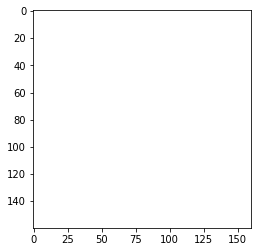

In [16]:
import matplotlib.pyplot as plt
plt.imshow(trainImgs[0])

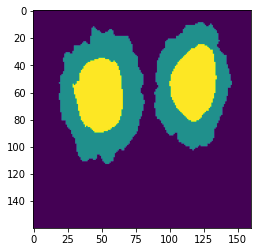

In [17]:
plt.imshow(validImgs[0])

In [30]:

from tensorflow.keras import layers
import tensorflow.keras as keras

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

# Build model
model = get_model(image_size, num_classes)
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics="acc")
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 80, 80, 32)   896         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_60 (BatchNo (None, 80, 80, 32)   128         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_60 (Activation)      (None, 80, 80, 32)   0           batch_normalization_60[0][0]     
____________________________________________________________________________________________

In [48]:
callbacks = [
    keras.callbacks.ModelCheckpoint(model_path(base_output_path), save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
model.fit(trainImgs, validImgs, epochs=epochs, callbacks=callbacks, validation_split=validation_split )

Epoch 1/30
17/17 [==============================] - 6s 328ms/step - loss: 0.1750 - acc: 0.9306 - val_loss: 1.0538 - val_acc: 0.6718

In [6]:
import tensorflow.keras as keras
model = keras.models.load_model(model_path(base_output_path))
result_imgs = model.predict(trainImgs)
print(result_imgs.shape)


../imagens_cra/train/cra found 659 img to load

[0]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[100]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[200]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[300]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[400]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[500]:|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
[600]:||||||||||||||||||||||||||||||||||||||||||||||||||||||||||(659, 160, 160, 3)


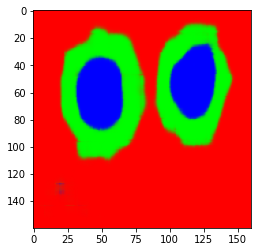

In [9]:
import matplotlib.pyplot as plt
plt.imshow(result_imgs[0])


(659, 160, 160)


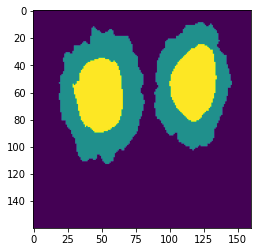

In [12]:
import numpy as np
print(validImgs.shape)
validImgs = np.expand_dims(validImgs, 3)
plt.imshow(validImgs[0])

In [7]:
import model_util
import tensorflow as tf

image_size = (160, 160)
epochs = 30
base_output_path = '..\\imagens_cra\\result\\unet_mean_iou_internal_externa_epoch_'+str(epochs)+'_size_'+str(image_size)
x_dir = "../imagens_cra/train/cra"
y_dir = "../imagens_cra/validation_interna_externa_v2/cra"
metric = tf.keras.metrics.Accuracy()

imgTester_metrics = [
    metric,
]

imgUtil = model_util.ImgTesterV2(x_dir, y_dir, base_output_path, image_size, imgTester_metrics)

model_util.test_v2(base_output_path, imgUtil, 5, 5)

KeyboardInterrupt: 